In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re
import requests
import time
import json

In [2]:
def req(prof):
    r = requests.get(f'https://api.vk.com/method/users.get?user_ids={prof}&fields=counters&access_token=/////&v=5.131')
    data_one = r.json()
    dt = data_one["response"][0]['counters']
    time.sleep(2)
    return dt

def filter(prof):
    prof = re.sub(r'https://', '', prof)
    prof = re.sub(r'http://', '', prof)
    prof = re.sub(r'vk.com/', '', prof)
    prof = re.sub(r'Vk.com/', '', prof)
    return prof

In [3]:
df = pd.read_csv('data_aizenk.csv', index_col=None, sep=',')
vk_profs = df["Укажите ссылку на ваш ВК (пример: 'vk.com/id111111111') (укажите, даже если профиль полностью пустой)"].to_list()
vk_profs = [prof for prof in vk_profs if prof != 'нет ВК']
filtered_profs = [filter(str(prof)) for prof in vk_profs]

In [4]:
for inx, col in enumerate(df.columns):
    if inx > 3:
        new_name = "".join(c for c in col if  c.isdecimal())
        df.rename(columns={col: new_name}, inplace=True)
# print(df.columns)
for i in range(1, len(df.columns)-3):
    df.loc[(df[str(i)] == "да"), str(i)] = 1
    df.loc[(df[str(i)] == "да (много)"), str(i)] = 1
    df.loc[(df[str(i)] == "нет (мало)"), str(i)] = 1
    df.loc[(df[str(i)] == "нет"), str(i)] = 0
df.drop(['Подписывая данную форму информированного согласия, я подтверждаю, что прочитал(а) и понял(а) цели, процедуру, методы и возможные неудобства участия в исследовании. У меня была возможность задать все интересующие меня вопросы. Я получил(а) удовлетворительные ответы и уточнения по всем вопросам, интересовавшим меня в связи с данным исследованием. Я даю свое согласие на участие в исследовании.'], axis=1, inplace=True)
df.drop(["Укажите ваш профиль Инстаграм (пример: '@cocacolarus')"], axis=1, inplace=True)
df.drop(["Отметка времени"], axis=1, inplace=True)
df.rename(columns={"Укажите ссылку на ваш ВК (пример: 'vk.com/id111111111') (укажите, даже если профиль полностью пустой)": "vk_id"}, inplace=True)
df = df.loc[df['vk_id'] != 'нет ВК']

df['vk_id'] = filtered_profs
df['ex1'] = df[['1','3','8','10','13','17','22','25','27','39','44','46','49','53','56']].sum(axis=1)
df['ex2'] = 9 - df[['5','15','20','29','32','34','37','41','51']].sum(axis=1)
df['ex'] = df.apply(lambda x: x['ex1'] + x['ex2'], axis=1)
df['neu'] = df[['2','4','7','9','11','14','16','19','21','23','26','28','31','33','35','38','40','43','45','47','50','52','55','57']].sum(axis=1)
df['lie1'] = df[['6','24','36']].sum(axis=1)
df['lie2'] = 6 - df[['12','18','30','42','48','54']].sum(axis=1)
df['lie'] = df.apply(lambda x: x['lie1'] + x['lie2'], axis=1)
df.drop(['1','3','8','10','13','17','22','25','27','39','44','46','49','53','56','5','15','20','29','32','34','37','41','51','2','4','7','9','11','14','16','19','21','23','26','28','31','33','35','38','40','43','45','47','50','52','55','57','6','24','36','12','18','30','42','48','54', 'lie1', 'lie2', 'ex1', 'ex2'], axis=1, inplace=True)

C:\Temp\ipykernel_19160\1113087407.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['ex2'] = 9 - df[['5','15','20','29','32','34','37','41','51']].sum(axis=1)


In [5]:
df.loc[:, df.columns!='vk_id']

,ex,neu,lie
0,18.0,7.0,0.0
1,16.0,20.0,3.0
2,19.0,19.0,1.0
3,16.0,15.0,3.0
4,14.0,7.0,2.0
...,...,...,...
115,17.0,18.0,3.0
116,19.0,18.0,3.0
117,18.0,11.0,3.0
118,17.0,15.0,2.0


In [6]:
# rez = []
# for proof in filtered_profs:
#    try:
#       rez.append(req(proof))
#    except:
#       rez.append(None)
# with open('json_data.json', 'w', encoding='utf8') as outfile:
#     json.dump(rez, outfile, ensure_ascii=False)
# print(rez) 

In [7]:
with open('json_data.json') as json_file:
    rez = json.load(json_file)

dic = {}
for inx, val in enumerate(rez):
    # print(inx)
    dic[filtered_profs[inx]] = val

df2 = pd.DataFrame.from_dict(dic)
df2 = df2.T
df2 = df2.rename_axis('vk_id').reset_index()
df2.head(7)
df_cd = pd.merge(df, df2, how='inner', on = 'vk_id')
df_cd.drop(columns=['online_friends', 'articles', 'wishes', 'clips_followers'], axis=1, inplace=True)
df_cd.fillna(0, inplace=True)
df_cd.head()

,vk_id,ex,neu,lie,albums,audios,followers,friends,pages,photos,subscriptions,videos,mutual_friends,gifts,user_photos,posts,groups
0,oreushka,18.0,7.0,0.0,1.0,0.0,46.0,175.0,29.0,14.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,lameus,16.0,20.0,3.0,3.0,1286.0,160.0,104.0,52.0,456.0,0.0,306.0,3.0,353.0,2.0,0.0,0.0
2,anastaaa10,19.0,19.0,1.0,0.0,1822.0,229.0,159.0,81.0,9.0,0.0,102.0,2.0,0.0,0.0,0.0,0.0
3,amlnkv,16.0,15.0,3.0,1.0,0.0,193.0,176.0,10.0,33.0,0.0,10.0,2.0,192.0,0.0,0.0,0.0
4,ssaaffiikk,14.0,7.0,2.0,0.0,0.0,0.0,28.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0


In [8]:
df_cd.loc[:, df_cd.columns!='vk_id']

,ex,neu,lie,albums,audios,followers,friends,pages,photos,subscriptions,videos,mutual_friends,gifts,user_photos,posts,groups
0,18.0,7.0,0.0,1.0,0.0,46.0,175.0,29.0,14.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,16.0,20.0,3.0,3.0,1286.0,160.0,104.0,52.0,456.0,0.0,306.0,3.0,353.0,2.0,0.0,0.0
2,19.0,19.0,1.0,0.0,1822.0,229.0,159.0,81.0,9.0,0.0,102.0,2.0,0.0,0.0,0.0,0.0
3,16.0,15.0,3.0,1.0,0.0,193.0,176.0,10.0,33.0,0.0,10.0,2.0,192.0,0.0,0.0,0.0
4,14.0,7.0,2.0,0.0,0.0,0.0,28.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,17.0,18.0,3.0,5.0,0.0,320.0,326.0,30.0,1092.0,0.0,16.0,1.0,0.0,0.0,0.0,0.0
105,19.0,18.0,3.0,2.0,0.0,96.0,159.0,18.0,37.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0
106,18.0,11.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,17.0,15.0,2.0,0.0,0.0,0.0,320.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


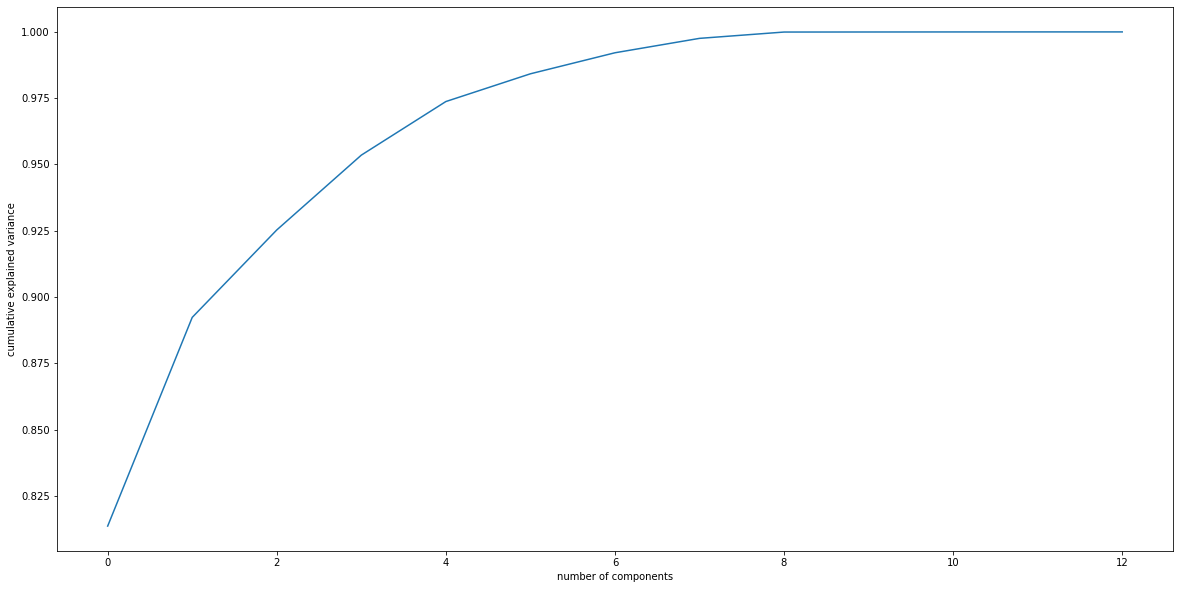

In [9]:
df_cd2 = df_cd[['albums','audios','followers','friends','pages','photos','subscriptions','videos','mutual_friends','gifts','user_photos','posts','groups']]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
pcd_df = df_cd2.select_dtypes(include=numerics)
pca = PCA().fit(pcd_df)
f = plt.figure(figsize=(20, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');